In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc
import random

In [2]:
with open('/home/husein/space/object-dataset/labels.csv', 'r') as fopen:
    data = fopen.read().split('\n')
    
for i in range(len(data)):
    data[i] = data[i].replace('"', '')
    data[i] = data[i].split()
    if len(data[i]) == 8:
        data[i][-2] = data[i][-2] + data[i][-1]
        data[i] = data[i][:-1]
        
df = pd.DataFrame(data)
df.columns = ['Frame', 'xmin', 'ymin', 'xmax', 'ymax', 'ind', 'Label']
df = df.dropna()
df[['xmin', 'ymin', 'xmax', 'ymax']] = df[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
df.head()

,Frame,xmin,ymin,xmax,ymax,ind,Label
0,1478019952686311006.jpg,950,574,1004,620,0,car
1,1478019952686311006.jpg,1748,482,1818,744,0,pedestrian
2,1478019953180167674.jpg,872,586,926,632,0,car
3,1478019953689774621.jpg,686,566,728,618,1,truck
4,1478019953689774621.jpg,716,578,764,622,0,car


In [3]:
IMG_ROW = 640
IMG_COL = 960
BATCH_SIZE = 1
EPOCH = 10
SMOOTH = 1.0
LEARNING_RATE = 0.0001
FILE_PATH = '/home/husein/space/object-dataset/'
UNIQUE_IMG = np.unique(df['Frame'])
COLORS = []
LABELS = np.unique(df['Label']).tolist()
for i in range(len(LABELS)):
    COLORS.append((random.random(), random.random(), random.random()))

In [4]:
print('total images:', UNIQUE_IMG.shape[0])
df.loc[df['Frame'] == UNIQUE_IMG[0]]

('total images:', 13063)


,Frame,xmin,ymin,xmax,ymax,ind,Label
0,1478019952686311006.jpg,950,574,1004,620,0,car
1,1478019952686311006.jpg,1748,482,1818,744,0,pedestrian


In [5]:
def read_img(img_name):
    img = misc.imread(FILE_PATH + img_name)
    img_size = img.shape
    img = misc.imresize(img, (IMG_ROW, IMG_COL))
    img_size_after = img.shape
    bboxes = df.loc[df['Frame'] == img_name].reset_index()
    bboxes['xmin'] = np.round(bboxes['xmin'] / img_size[1] * img_size_after[1])
    bboxes['xmax'] = np.round(bboxes['xmax'] / img_size[1] * img_size_after[1])
    bboxes['ymin'] = np.round(bboxes['ymin'] / img_size[0] * img_size_after[0])
    bboxes['ymax'] = np.round(bboxes['ymax'] / img_size[0] * img_size_after[0])
    img_mask = np.zeros((IMG_ROW, IMG_COL, 1))
    for i in range(bboxes.shape[0]):
        img_mask[int(bboxes['ymin'][i]): int(bboxes['ymax'][i]), int(bboxes['xmin'][i]): int(bboxes['xmax'][i]), 0] = 1.
    return img, img_mask, bboxes

def plot_image(img, img_mask, bboxes):
    fig = plt.figure(figsize = (15, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    for i in range(bboxes.shape[0]):
        rect = plt.Rectangle((bboxes['xmin'][i], bboxes['ymin'][i]), bboxes['xmax'][i] - bboxes['xmin'][i],
                                 bboxes['ymax'][i] - bboxes['ymin'][i], fill = False,
                                 edgecolor = COLORS[LABELS.index(bboxes['Label'][i])], linewidth= 1.5)
        plt.gca().add_patch(rect)
        plt.gca().text(bboxes['xmin'][i], bboxes['ymin'][i] - 2,
                           '{:s}'.format(bboxes['Label'][i]),
                           bbox=dict(facecolor = COLORS[LABELS.index(bboxes['Label'][i])], alpha=0.5),
                           fontsize=12, color='white')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(img_mask[:, :, 0])
    plt.axis('off')
    plt.tight_layout()
    plt.show()

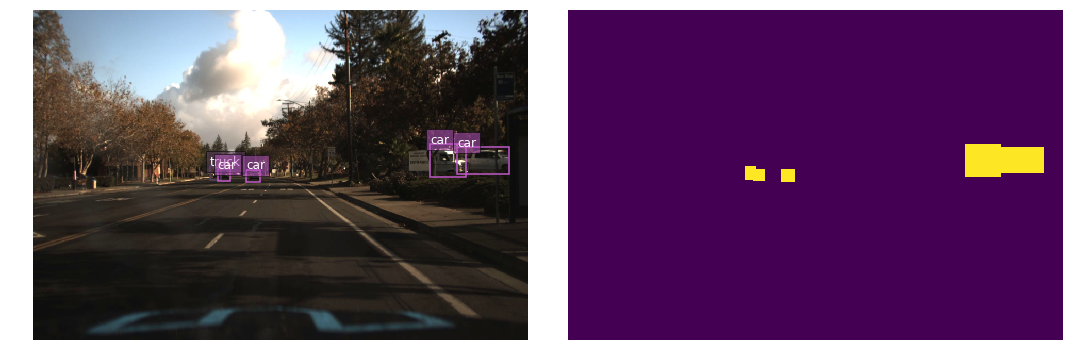

In [6]:
img, img_mask, bboxes = read_img(UNIQUE_IMG[2])
plot_image(img, img_mask, bboxes)

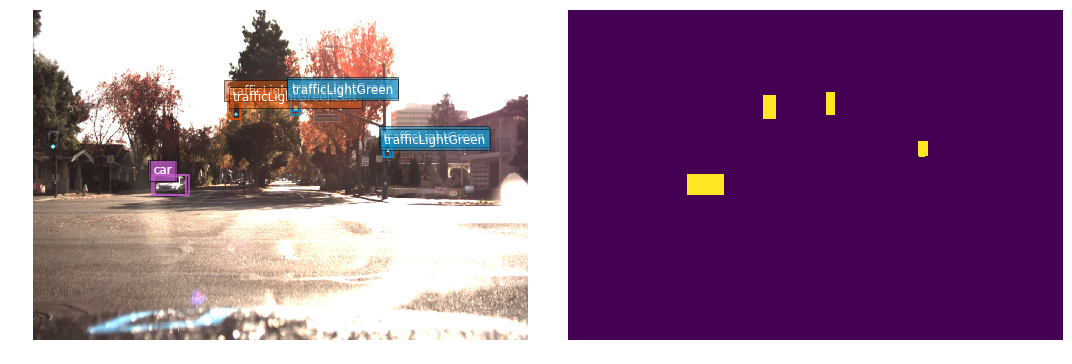

In [7]:
img, img_mask, bboxes = read_img(UNIQUE_IMG[100])
plot_image(img, img_mask, bboxes)

In [8]:
def IOU_calc(y_true, y_pred):
    y_true_f = tf.contrib.layers.flatten(y_true)
    y_pred_f = tf.contrib.layers.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 2 * (intersection + SMOOTH) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + SMOOTH)

def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

def conv_layer(x, conv, out_shape, name, stride = 1):
    w = tf.Variable(tf.truncated_normal([conv, conv, int(x.shape[3]), out_shape]), name = name + '_w')
    b = tf.Variable(tf.truncated_normal([out_shape], stddev = 0.01), name = name + '_b')
    return tf.nn.conv2d(x, w, [1, stride, stride, 1], padding = 'SAME') + b

def pooling(x, k = 2, stride = 2):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, stride, stride, 1], padding = 'SAME')

In [9]:
class Model:
    
    def __init__(self):
        self.X = tf.placeholder('float', [None, IMG_ROW, IMG_COL, 3])
        self.Y = tf.placeholder('float', [None, IMG_ROW, IMG_COL, 1])
        
        conv1 = tf.nn.relu(conv_layer(self.X, 3, 8, 'conv1_1', stride = 1))
        conv1 = tf.nn.relu(conv_layer(conv1, 3, 8, 'conv1_2', stride = 1))
        pool1 = pooling(conv1, k = 2, stride = 2)
        
        conv2 = tf.nn.relu(conv_layer(pool1, 3, 16, 'conv2_1', stride = 1))
        conv2 = tf.nn.relu(conv_layer(conv2, 3, 16, 'conv2_2', stride = 1))
        pool2 = pooling(conv2, k = 2, stride = 2)
        
        conv3 = tf.nn.relu(conv_layer(pool2, 3, 32, 'conv3_1', stride = 1))
        conv3 = tf.nn.relu(conv_layer(conv3, 3, 32, 'conv3_2', stride = 1))
        pool3 = pooling(conv3, k = 2, stride = 2)
        
        conv4 = tf.nn.relu(conv_layer(pool3, 3, 64, 'conv4_1', stride = 1))
        conv4 = tf.nn.relu(conv_layer(conv4, 3, 64, 'conv4_2', stride = 1))
        pool4 = pooling(conv4, k = 2, stride = 2)
        
        conv5 = tf.nn.relu(conv_layer(pool4, 3, 128, 'conv5_1', stride = 1))
        conv5 = tf.nn.relu(conv_layer(conv5, 3, 128, 'conv5_2', stride = 1))
        
        up6 = tf.concat([tf.image.resize_images(conv5, (int(conv5.shape[1]) * 2, int(conv5.shape[2]) * 2)),
                        conv4], axis = 3)
        conv6 = tf.nn.relu(conv_layer(up6, 3, 64, 'conv6_1', stride = 1))
        conv6 = tf.nn.relu(conv_layer(conv6, 3, 64, 'conv6_2', stride = 1))
        
        up7 = tf.concat([tf.image.resize_images(conv6, (int(conv6.shape[1]) * 2, int(conv6.shape[2]) * 2)),
                        conv3], axis = 3)
        conv7 = tf.nn.relu(conv_layer(up7, 3, 32, 'conv7_1', stride = 1))
        conv7 = tf.nn.relu(conv_layer(conv7, 3, 32, 'conv7_2', stride = 1))
        
        up8 = tf.concat([tf.image.resize_images(conv7, (int(conv7.shape[1]) * 2, int(conv7.shape[2]) * 2)),
                        conv2], axis = 3)
        conv8 = tf.nn.relu(conv_layer(up8, 3, 16, 'conv8_1', stride = 1))
        conv8 = tf.nn.relu(conv_layer(conv8, 3, 16, 'conv8_2', stride = 1))
        
        up9 = tf.concat([tf.image.resize_images(conv8, (int(conv8.shape[1]) * 2, int(conv8.shape[2]) * 2)),
                        conv1], axis = 3)
        conv9 = tf.nn.relu(conv_layer(up9, 3, 32, 'conv9_1', stride = 1))
        conv9 = tf.nn.relu(conv_layer(conv9, 3, 32, 'conv9_2', stride = 1))
        
        self.conv10 = tf.nn.sigmoid(conv_layer(conv9, 1, 1, 'conv10', stride = 1))
        self.cost = IOU_calc_loss(self.Y, self.conv10)
        self.optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(self.cost)
        self.accuracy = IOU_calc(self.Y, self.conv10)

In [ ]:
sess = tf.InteractiveSession()
model = Model()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())

In [ ]:
for i in range(EPOCH):
    total_loss, total_acc = 0, 0
    for k in range(UNIQUE_IMG.shape[0]):
        batch_x = np.zeros((1, IMG_ROW, IMG_COL, 3))
        batch_y = np.zeros((1, IMG_ROW, IMG_COL, 1))
        img, img_mask, _ = read_img(UNIQUE_IMG[k])
        batch_x[0, :, :, :] = img
        batch_y[0, :, :, :] = img_mask
        loss, _ = sess.run([model.cost, model.optimizer], feed_dict = {model.X: batch_x, model.Y: batch_y})
        total_acc += sess.run(model.accuracy, feed_dict = {model.X: batch_x, model.Y: batch_y})
        total_loss += loss
    total_loss /= UNIQUE_IMG.shape[0]
    total_acc /= UNIQUE_IMG.shape[0]
    print('epoch:', epoch + 1, 'avg accuracy:', total_acc, 'avg loss:', total_loss)